current state: start


100%|██████████| 32/32 [00:00<00:00, 30968.56it/s]


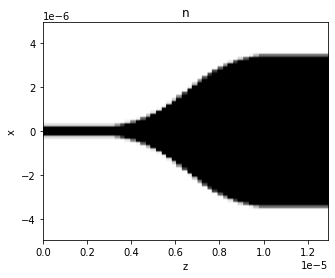

In [1]:
import emepy
from emepy.eme import Layer, EME
from emepy.mode import Mode
from emepy.fd import MSEMpy
import numpy as np
from matplotlib import pyplot as plt

# Design parameters
taper_length = 7e-6  # The length of the taper
taper_density = 30 # Number of taper segments
alpha = 3 # Strength of function (either tanh or bezier) -> 0 = linear
type_tanh = True # "bezier"

def taper_func(start, end, num_points):

    # Linear Curve
    x = np.linspace(width1, width2, taper_density)

    # Tanh Curve
    xt = x - np.min(x)
    xta = xt / np.max(xt)
    tanh = np.tanh(alpha*(xta-0.5))+1
    tanh -= np.min(tanh)
    tanh *= np.max(xt) / np.max(tanh)
    tanh += np.min(x)
    return tanh

# Geometric parameters
width1 = 0.5e-6  # Width of left waveguide
thickness1 = 0.22e-6  # Thickness of left waveguide
width2 = 7e-6  # Width of right waveguide
thickness2 = 0.22e-6  # Thickness of right waveguide
wavelength = 1.55e-6  # Wavelength of light (m)
length = 3e-6  # Length of the waveguides
num_modes_first_half = 10 # Number of modes to solve for
num_modes_second_half = 20 # Number of modes to solve for
mesh=70 # Number of mesh points in each xy dimension

eme = EME()  # Choose either a normal eme or a periodic eme (PeriodicEME())

# first layer is a straight waveguide
mode1 = MSEMpy(
    wavelength,
    width1,
    thickness1,
    num_modes=3,
    cladding_width=10e-6,
    cladding_thickness=10e-6,
    mesh=mesh,
    subpixel=True
)
straight1 = Layer(mode1, 3, wavelength, length)
eme.add_layer(straight1)

# create the discrete taper with a fine enough taper density to approximate a continuous linear taper
widths = taper_func(width1, width2, taper_density)
thicknesses = np.linspace(thickness1, thickness2, taper_density)
taper_length_per = taper_length / taper_density

# add the taper layers
for i in range(taper_density):
    num_modes = num_modes_first_half if i < taper_density / 2.0 else num_modes_second_half
    solver = MSEMpy(wavelength, widths[i], thicknesses[i], num_modes=num_modes, mesh=mesh,cladding_width=10e-6,cladding_thickness=10e-6,subpixel=True)
    taper_layer = Layer(solver, num_modes, wavelength, taper_length_per)
    eme.add_layer(taper_layer)

# last layer is a straight waveguide of smaller geometry
mode2 = MSEMpy(wavelength, width2, thickness2, num_modes=num_modes_second_half, mesh=mesh,cladding_width=10e-6,cladding_thickness=10e-6,subpixel=True)
straight2 = Layer(mode2, num_modes_second_half, wavelength, length)
eme.add_layer(straight2)

monitor = eme.add_monitor(axes="xz")

eme.draw() 
plt.show()